In [1]:
# Print runtime spec
import os
import platform
import psutil
import subprocess

# CPU info
print("=== CPU Info ===")
print(f"Processor: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical / {psutil.cpu_count()} logical")
cpu_freq = psutil.cpu_freq()
if cpu_freq:
    print(f"CPU Frequency: {cpu_freq.current:.2f} MHz")

# RAM info
print("\n=== RAM Info ===")
ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024 ** 3):.2f} GB")
print(f"Available RAM: {ram.available / (1024 ** 3):.2f} GB")

# GPU info (NVIDIA)
print("\n=== GPU Info ===")
try:
    result = subprocess.run(
        ['nvidia-smi', '--query-gpu=name,memory.total,memory.used,driver_version', '--format=csv,noheader,nounits'],
        stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True, text=True
    )
    gpus = result.stdout.strip().split('\n')
    for idx, gpu in enumerate(gpus):
        name, mem_total, mem_used, driver = [x.strip() for x in gpu.split(',')]
        print(f"GPU {idx}: {name}")
        print(f"  Total Memory: {mem_total} MB")
        print(f"  Used Memory: {mem_used} MB")
        print(f"  Driver Version: {driver}")
except FileNotFoundError:
    print("nvidia-smi not found. NVIDIA GPU may not be installed.")
except subprocess.CalledProcessError as e:
    print(f"Error running nvidia-smi: {e}")


=== CPU Info ===
Processor: x86_64
CPU Cores: 6 physical / 12 logical
CPU Frequency: 2200.27 MHz

=== RAM Info ===
Total RAM: 83.48 GB
Available RAM: 81.91 GB

=== GPU Info ===
GPU 0: NVIDIA A100-SXM4-40GB
  Total Memory: 40960 MB
  Used Memory: 0 MB
  Driver Version: 550.54.15


Usage rate: approximately 6.86 per hour

In [2]:
!pip install -q scanpy==1.10.1
!pip install -q anndata==0.10.7
!pip install -q leidenalg==0.10.2

# !pip install rapids-singlecell
!pip install -q 'rapids-singlecell[rapids12]' --extra-index-url=https://pypi.nvidia.com #CUDA12
!pip install -q rmm-cu12 # RMM: RAPIDS Memory Manager

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 111.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 200.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 M

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

from matplotlib import pyplot as plt
from matplotlib.pyplot import rc_context

import warnings

warnings.filterwarnings("ignore")

In [4]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import auth # Authenticate your Colab environment to access your Google Cloud account.
auth.authenticate_user()

Mounted at /content/drive


# Prepare anndata

In [ ]:
%%time
co_stains = ['RA', 'RO']
for stain in co_stains:
    print(f"Preparing {stain}")


    # directly load from https://info.vizgen.com/protein-co-detection-showcase?submissionGuid=b2c89505-7fbc-453a-bbe0-0add9691c2fe
    cell_by_gene_csv = f'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-{stain}Costain/cell_by_gene.csv'
    meta_cell_csv = f'gs://vz-ffpe-showcase/HumanUterineCancerPatient2-{stain}Costain/cell_metadata.csv'


    def make_AnnData(cell_by_gene_path, meta_cell_path): #, frac, random_state): #Prepare full dataset

        cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
        cell_by_gene.index = [str(i) for i in cell_by_gene.index] # this ensure the cell IDs are strings
        # cell_by_gene = cell_by_gene.sample(frac = frac, random_state= random_state)

        meta_cell = pd.read_csv(meta_cell_path, index_col=0)
        meta_cell.index = [str(i) for i in meta_cell.index] # this ensure the cell IDs are strings
        # meta_cell = meta_cell.sample(frac = frac, random_state= random_state)

        meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)

        # initialize meta_gene
        meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

        # Align the cell id of cell_by_gene and cell_metadata
        cell_id = cell_by_gene.index.tolist()
        meta_cell = meta_cell.loc[cell_id]

        coordinates =np.stack((meta_cell['center_x'], meta_cell['center_y']), axis=1)

        ad = sc.AnnData(X=cell_by_gene.values, obs=meta_cell, var=meta_gene, obsm={"spatial": coordinates})
        return ad


    ad = make_AnnData(cell_by_gene_csv, meta_cell_csv) #, frac = 0.1, random_state=1128) #Prepare full dataset
    # Filtering out blank genes
    ad = ad[:, ad.var_names.str.startswith('Blank-')==False]

    # save all cell IDs for later importing into the Vizualizer
    all_cell_IDs = ad.obs.index.copy()

    # Store the counts for later use
    ad.layers["counts"] = ad.X.copy()

    # Store batch info
    ad.obs['batch'] = stain

    ad.write_h5ad(f"/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-{stain}Costain_full_data.hdf5")

    display(ad)

Preparing RA


AnnData object with n_obs × n_vars = 741749 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Anti-Ms-CD45RA_raw', 'Anti-Ms-CD45RA_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'barcodeCount', 'batch'
    obsm: 'spatial'
    layers: 'counts'

Preparing RO


AnnData object with n_obs × n_vars = 758506 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'barcodeCount', 'batch'
    obsm: 'spatial'
    layers: 'counts'

CPU times: user 1min 23s, sys: 6min 9s, total: 7min 32s
Wall time: 22min 21s


# Load h5ad data

https://rapids-singlecell.readthedocs.io/en/latest/notebooks/01_demo_gpu.html

In [6]:
data_load_start = time.time()

In [7]:
%%time
ro_adata = sc.read_h5ad("/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-ROCostain_full_data.hdf5")
ro_adata.obs['batch'] = 'CD45RO'
ra_adata = sc.read_h5ad("/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-RACostain_full_data.hdf5")
ra_adata.obs['batch'] = 'CD45RA'

# concatenate anndata
adata = ra_adata.concatenate(ro_adata)

# the initial 'batch' annotation was overwrite during concatenate, let's use CD45RA and CD45RO signal to assign batch name
adata.obs['batch'] = np.where(~adata.obs['Anti-Ms-CD45RA_raw'].isna(), 'CD45RA', 'CD45RO')

# adata = ro_adata.copy()


# free up ram
import gc

# Delete the object and force garbage collection
del ro_adata
del ra_adata

# Run garbage collection manually
gc.collect()

adata

CPU times: user 6.51 s, sys: 17.2 s, total: 23.7 s
Wall time: 2min 16s


AnnData object with n_obs × n_vars = 1500255 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Anti-Ms-CD45RA_raw', 'Anti-Ms-CD45RA_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'barcodeCount', 'batch', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass'
    obsm: 'spatial'
    layers: 'counts'

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 136.2415268421173


# Preprocessing

In [9]:
preprocess_start = time.time()

In [10]:
# Filter cells based on minimum gene expression counts and volume
print("Cell number before filtering = ", len(adata))


# set the threshold
min_barcode_count_threshold = 20
volume_upper_threshold = 2500
volume_lower_threshold = 100

selectCells = adata.obs[(adata.obs.volume < volume_upper_threshold)
                   & (adata.obs.volume > volume_lower_threshold)
                   & (adata.obs.barcodeCount > min_barcode_count_threshold)].index


adata = adata[selectCells].copy()
print("Cell number after filtering = ", len(adata))

Cell number before filtering =  1500255
Cell number after filtering =  1469933


In [11]:
# manually trigger garbage collection to reclaim memory
%%time
gc.collect()

CPU times: user 226 ms, sys: 540 ms, total: 765 ms
Wall time: 758 ms


336

In [12]:
# Normalize barcode counts by cell volume
adata.obs['volume_factor'] = adata.obs['volume']/np.median(adata.obs['volume'])
adata.X = np.divide(adata.X, np.array(adata.obs['volume_factor']).reshape(-1, 1))

# Store raw data in the .raw attribute before scaling
# adata.raw = adata.copy() # Skip, this makes the adata too big for the system RAM


In [13]:
%%time
rsc.get.anndata_to_GPU(adata) # load the the AnnData object into VRAM

CPU times: user 1.11 s, sys: 3.63 s, total: 4.73 s
Wall time: 4.77 s


In [14]:
%%time
rsc.get.anndata_to_CPU(adata, layer="counts") # move raw counts to CPU to save ram

CPU times: user 30 µs, sys: 35 µs, total: 65 µs
Wall time: 68.7 µs


In [15]:
# Normalize barcode counts by total counts over all genes and log transform data
rsc.pp.normalize_total(adata)
rsc.pp.log1p(adata)

In [16]:
%%time
adata.raw = adata #safe this version of the AnnData as adata.raw.

CPU times: user 1.09 s, sys: 979 ms, total: 2.07 s
Wall time: 2.06 s


In [17]:
# scale gene counts
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 1.14 s, sys: 17.7 ms, total: 1.16 s
Wall time: 1.15 s


In [18]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 32.101821184158325


# Principal component analysis

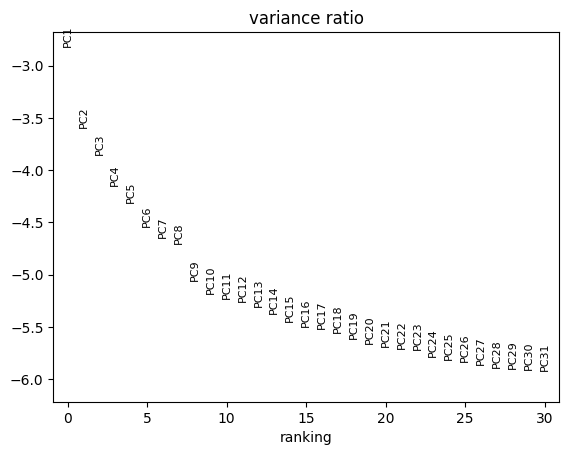

CPU times: user 926 ms, sys: 176 ms, total: 1.1 s
Wall time: 1.37 s


In [19]:
%%time
rsc.tl.pca(adata) #svd_solver='arpack'
sc.pl.pca_variance_ratio(adata, log=True)

#transfer the .X matrix back to host (CPU) memory to free up GPU resources
rsc.get.anndata_to_CPU(adata)

# Clustering

In [20]:
clustering_start = time.time()

In [21]:
# Computing the neighborhood graph and UMAP
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=None)

CPU times: user 41.8 s, sys: 499 ms, total: 42.3 s
Wall time: 42.2 s


In [22]:
%%time
rsc.tl.umap(adata)

CPU times: user 2.73 s, sys: 349 ms, total: 3.08 s
Wall time: 3.06 s


In [23]:
%%time
rsc.tl.leiden(adata, resolution=1.5)

CPU times: user 4.79 s, sys: 1.28 s, total: 6.07 s
Wall time: 11 s


In [24]:
clustering_time = time.time()
print("Total Clustering time: %s" % (clustering_time - clustering_start))

Total Clustering time: 56.2723433971405


adata.write_h5ad("/content/drive/MyDrive/Cancer sc analysis/HumanUterineCancerPatient2-RORACostain_full_clustered.hdf5")

# Differential expression analysis

In [25]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="leiden", use_raw=False)

CPU times: user 7.56 s, sys: 843 ms, total: 8.41 s
Wall time: 8.68 s


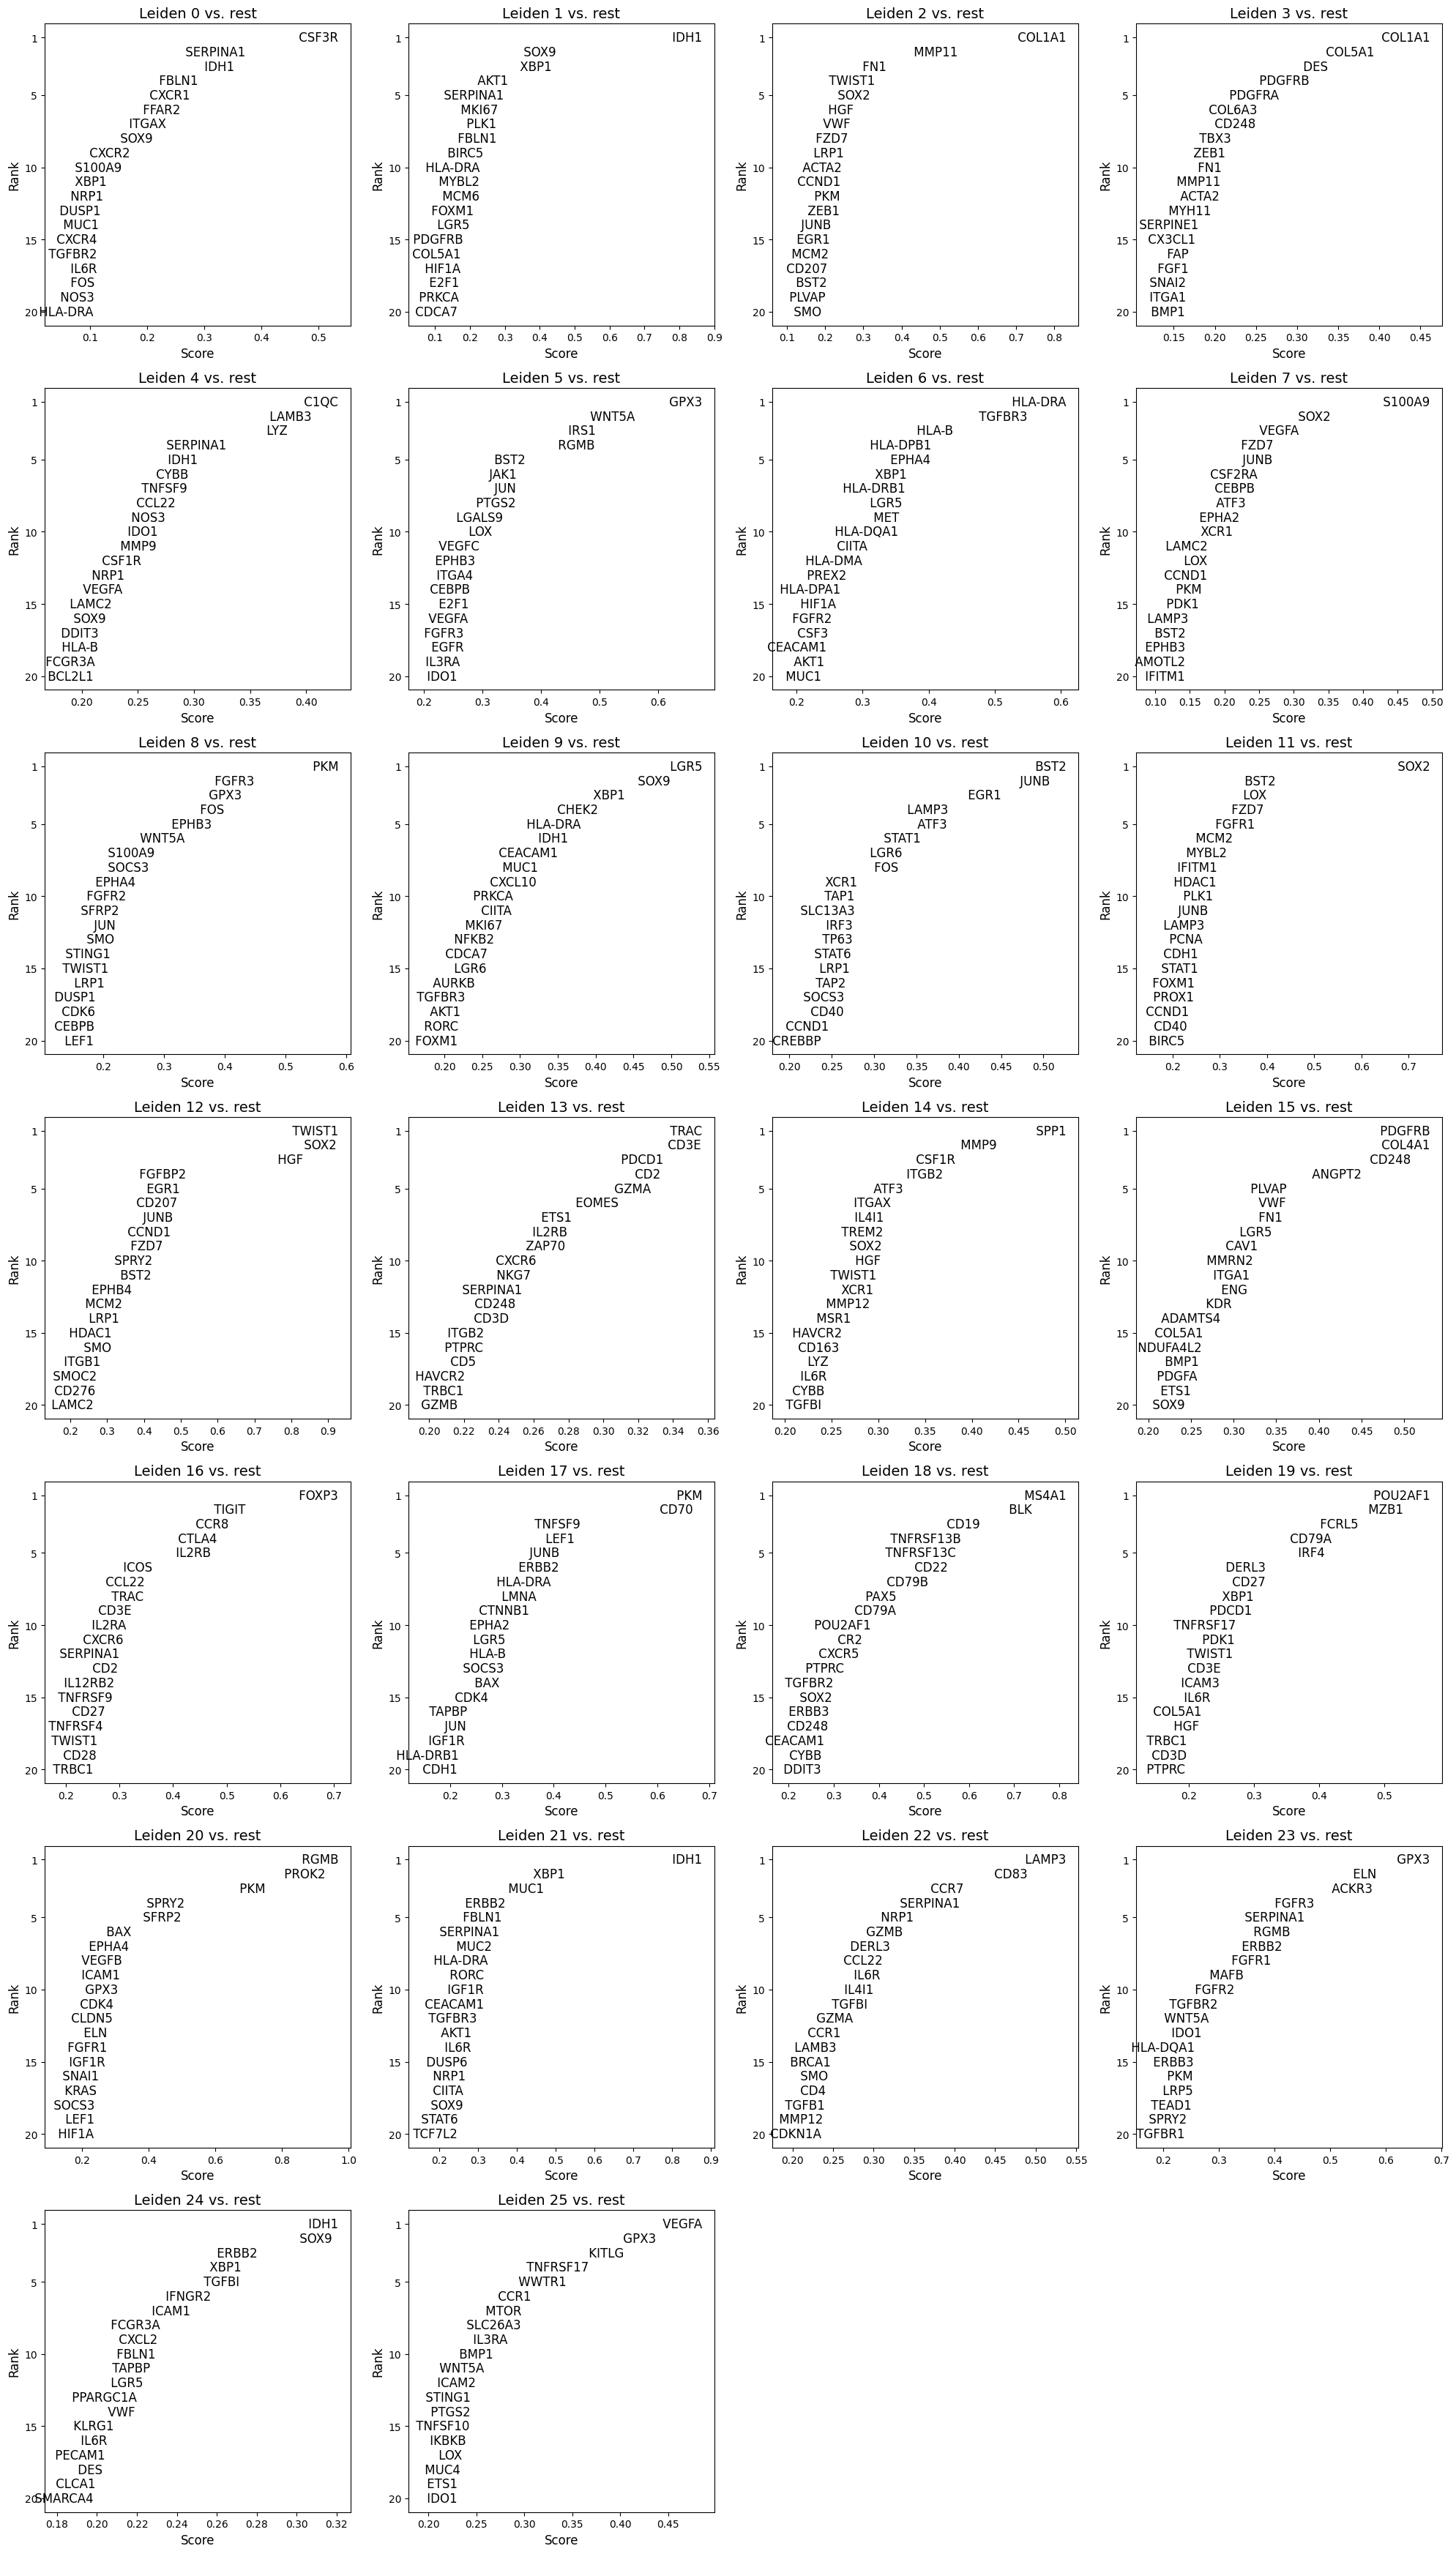

In [26]:
# Plot gene rank
# swop x and y axis to make gene names in horizontal for better visualization

import math

# Number of clusters
n_clusters = len(adata.obs['leiden'].unique())
n_genes = 20  # Number of genes to visualize

# Compute number of columns and rows automatically (e.g., 4 columns)
n_cols = 4
n_rows = math.ceil(n_clusters / n_cols)

# Define subplot size
subplot_width = 5
subplot_height = 5

# Create the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * subplot_width, n_rows * subplot_height))
axes = axes.flatten()

# Loop over each Leiden cluster
for i in range(n_clusters):
    group = str(i)
    ax = axes[i]

    genes = adata.uns['rank_genes_groups']['names'][group][:n_genes]
    scores = adata.uns['rank_genes_groups']['scores'][group][:n_genes]

    data = pd.DataFrame({'Rank': range(1, n_genes + 1), 'Gene': genes, 'Score': scores})

    ax.scatter(data['Score'], data['Rank'], color='blue', s=0)
    ax.invert_yaxis()

    for j, row in data.iterrows():
        ax.text(row['Score'], row['Rank'], f" {row['Gene']}", va='center', ha='right', fontsize=12)

    ax.set_yticks([1, 5, 10, 15, 20])
    ax.set_yticklabels([1, 5, 10, 15, 20])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    xmin = data['Score'].min() - (data['Score'].max() - data['Score'].min()) * 0.2
    ax.set_xlim(xmin, None)

    ax.set_title(f'Leiden {group} vs. rest', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Rank', fontsize=12)

# Turn off unused axes
for i in range(n_clusters, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [27]:
post_time = time.time()

In [28]:
print("Total Postprocessing time: %s" % (post_time - preprocess_time))

Total Postprocessing time: 69.97232556343079


In [29]:
#transfer the .X matrix back to host (CPU) memory to free up GPU resources
rsc.get.anndata_to_CPU(adata)

In [30]:
adata

AnnData object with n_obs × n_vars = 1469933 × 500
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'Cellbound2_raw', 'Cellbound2_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'Anti-Ms-CD45RA_raw', 'Anti-Ms-CD45RA_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'barcodeCount', 'batch', 'Anti-Ms-CD45RO_raw', 'Anti-Ms-CD45RO_high_pass', 'volume_factor', 'leiden'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
# print out session information
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.8.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
anndata                               0.10.7
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array-api-compat                      1.12.0
array_record                          0.7.2
arviz                                 0.21.0
astrop